In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [110]:
# Caricamento dei dati
data = pd.read_csv('data.csv')

# Assicurati che i dati siano numerici
data = data.astype({'SampleTime': 'float64', 'SensorID': 'float64', 'Value': 'float64'})

# Visualizzazione delle prime righe per confermare il caricamento
print(data.head(5))

   SampleTime  SensorID     Value
0         0.0       2.0  0.033883
1         0.0       4.0 -0.009496
2         0.0       5.0  0.000000
3         0.0       7.0 -0.057306
4         0.0       8.0  0.029096


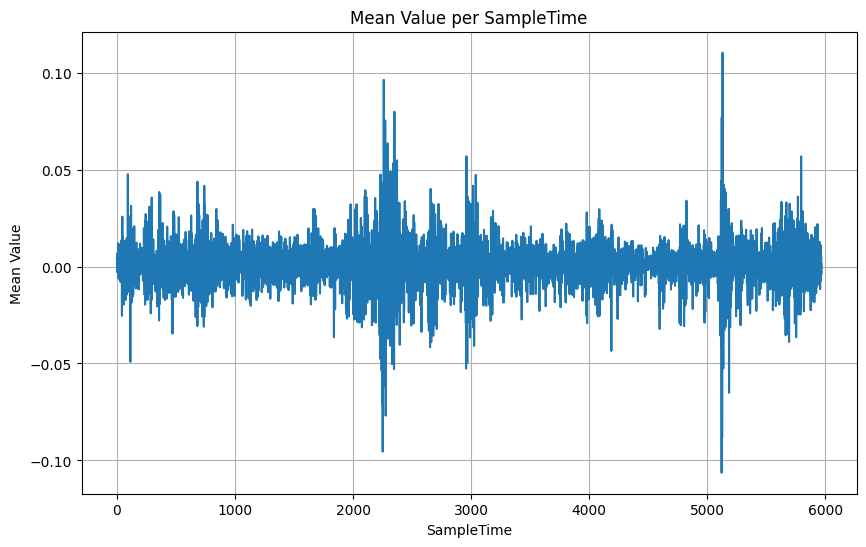

In [111]:
# Calcola la media dei valori per ogni SampleTime
mean_values = data.groupby('SampleTime')['Value'].mean()

# Plot della media dei valori per SampleTime
plt.figure(figsize=(10, 6))
plt.plot(mean_values.index, mean_values.values)
plt.xlabel('SampleTime')
plt.ylabel('Mean Value')
plt.title('Mean Value per SampleTime')
plt.grid(True)
plt.show()

In [112]:
def offline_phase_PCA(sliding_window, gamma=0.95, fraction=0.5, random_state=42):
    """
    Calcola i set S1 e S2, il modello PCA per S1, la media campionaria, la matrice di covarianza,
    gli autovalori e gli autovettori di Q, e la matrice V basata sul livello desiderato di gamma.
    Inoltre, calcola rj e ||rj||_{2} per ogni xj in S2 e ordina ||rj||_{2} in ordine crescente.
    
    Parameters:
    sliding_window (np.ndarray): La finestra scorrevole dei dati.
    gamma (float): Il livello desiderato di gamma per determinare r.
    fraction (float): La frazione dei dati da includere in S1.
    random_state (int): Il seme per il generatore di numeri casuali.
    
    Returns:
    mean_x (np.ndarray): La media campionaria di S1.
    V (np.ndarray): La matrice V formata dagli autovettori corrispondenti agli r maggiori autovalori.
    sorted_residuals (list): Lista dei valori ||rj||_{2} per ogni xj in S2, ordinati in ordine crescente.
    """
    # Suddividi la finestra scorrevole in S1 e S2
    N = len(sliding_window)
    indices = np.arange(N)
    np.random.seed(random_state)
    np.random.shuffle(indices)
    split_point = int(fraction * N)
    S1 = sliding_window[indices[:split_point]]
    S2 = sliding_window[indices[split_point:]]
    
    # Calcola la media campionaria di S1
    mean_x = np.mean(S1, axis=0)
    
    # Calcola la matrice di covarianza di S1
    Q = np.cov(S1, rowvar=False)
    
    # Calcola gli autovalori e autovettori della matrice di covarianza Q
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    
    # Determina r basato sul livello desiderato di gamma
    total_variance = np.sum(eigenvalues)
    variance_retained = 0
    r = 0
    for i in range(len(eigenvalues)-1, -1, -1):
        variance_retained += eigenvalues[i]
        r += 1
        if variance_retained / total_variance >= gamma:
            break
    
    # Forma la matrice V con gli autovettori corrispondenti ai r maggiori autovalori
    V = eigenvectors[:, -r:]
    
    # Calcola rj e ||rj||_{2} per ogni xj in S2
    residuals = []
    for xj in S2:
        rj = (np.eye(len(mean_x)) - V @ V.T) @ (xj - mean_x)
        residual_norm = np.linalg.norm(rj, 2)
        residuals.append(residual_norm)
    
    # Ordina i valori ||rj||_{2} in ordine crescente
    sorted_residuals = sorted(residuals)
    
    return mean_x, V, sorted_residuals

In [113]:
t = 0
g_t = 0
alpha = 0.2  # Livello di significatività
h = 25  # Soglia per la statistica decisionale
anomalies = []

# Inizializzazione del tempo t
W = 100  # Ampiezza della finestra scorrevole
t = W  # Inizializza t in modo che ci siano almeno W istanti precedenti

# Ottieni i valori dei sensori ordinati per SampleTime e SensorID
sensor_values = data.pivot(index='SampleTime', columns='SensorID', values='Value').fillna(0)
print(f"Dimensioni di sensor_values: {sensor_values.shape}")

# Definisci la lunghezza del ciclo
num_iterations = len(sensor_values) - W  # Assicurati di non superare la lunghezza dei dati

Dimensioni di sensor_values: (5967, 999)


In [114]:
# Ciclo per elaborare i nuovi dati con barra di avanzamento
for i in tqdm(range(num_iterations)):
    # Crea la finestra scorrevole
    sliding_window = sensor_values.iloc[t-W:t].values
    
    # Chiamata alla funzione offline_phase_PCA
    mean_x, V, sorted_residuals = offline_phase_PCA(sliding_window)
    
    # Ottieni il nuovo punto dati x_t
    x_t = sensor_values.iloc[t].values
    
    # Calcola r_t per il nuovo punto dati x_t
    r_t = (np.eye(len(mean_x)) - V @ V.T) @ (x_t - mean_x)
    residual_norm_t = np.linalg.norm(r_t, 2)
    
    # Calcola p_t
    p_t = np.sum(np.array(sorted_residuals) > residual_norm_t) / len(sorted_residuals)
    
    # Gestisci il caso di p_t pari a zero
    if p_t == 0:
        p_t = 1 / len(sorted_residuals)
    
    # Calcola la statistica di evidenza s_t
    s_t = np.log(alpha / p_t)
    
    # Aggiorna la statistica decisionale g_t
    g_t = max(0, g_t + s_t)
    
    # Controlla se g_t supera la soglia h
    if g_t >= h:
        print(f"Anomalia rilevata al tempo t={t} con g_t={g_t}")
        print(f"Valore medio di x_t: {np.mean(x_t)}")
        anomalies.append(sensor_values.index[t])  # Salva l'istante di tempo dell'anomalia
        g_t = 0  # Resetta g_t
    
    t += 1

 10%|▉         | 584/5867 [03:24<26:21,  3.34it/s]  

Anomalia rilevata al tempo t=683 con g_t=25.72249023731519
Valore medio di x_t: -0.002400699699699699


 37%|███▋      | 2158/5867 [11:39<22:47,  2.71it/s]  

Anomalia rilevata al tempo t=2257 con g_t=25.889236067338942
Valore medio di x_t: -0.010914133133133132


 86%|████████▌ | 5025/5867 [29:56<04:55,  2.85it/s]

Anomalia rilevata al tempo t=5124 con g_t=27.236984087787178
Valore medio di x_t: 0.03452368568568568


100%|██████████| 5867/5867 [35:20<00:00,  2.77it/s]


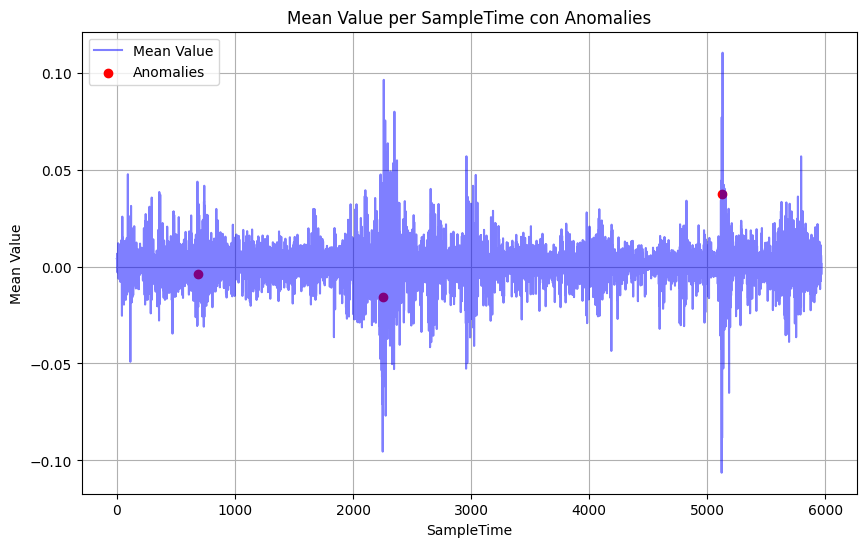

In [115]:
# Plot dei dati
plt.figure(figsize=(10, 6))
plt.plot(mean_values.index, mean_values.values, color='blue', alpha=0.5, label='Mean Value')
if anomalies:
    anomaly_times = pd.Series([1] * len(anomalies), index=anomalies)
    plt.scatter(anomaly_times.index, mean_values[anomalies], color='red', label='Anomalies')
plt.xlabel('SampleTime')
plt.ylabel('Mean Value')
plt.title('Mean Value per SampleTime con Anomalies')
plt.legend()
plt.grid(True)
plt.show()